In [28]:
from google.colab import files
uploaded = files.upload()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv('varejo_churn_academia.csv')

df.head()

,cliente_id,idade,genero,tempo_meses_plano,frequencia_semanal,tipo_plano,valor_mensal,reclamacoes_ult_3m,churn
0,1,56,M,37,0.1,Trimestral,99.54,0,0
1,2,46,F,5,5.2,Mensal,95.96,1,0
2,3,32,F,19,3.2,Mensal,234.64,0,0
3,4,60,F,59,5.6,Mensal,193.76,1,0
4,5,25,M,14,4.8,Mensal,220.98,0,1


In [30]:

df_modelo = df.drop(columns=['cliente_id'])

df_modelo = pd.get_dummies(df_modelo, columns=['genero', 'tipo_plano'], drop_first=True)

print("Novas colunas após o tratamento:")
print(df_modelo.columns)
df_modelo.head()

Novas colunas após o tratamento:
Index(['idade', 'tempo_meses_plano', 'frequencia_semanal', 'valor_mensal',
       'reclamacoes_ult_3m', 'churn', 'genero_M', 'tipo_plano_Mensal',
       'tipo_plano_Trimestral'],
      dtype='object')


,idade,tempo_meses_plano,frequencia_semanal,valor_mensal,reclamacoes_ult_3m,churn,genero_M,tipo_plano_Mensal,tipo_plano_Trimestral
0,56,37,0.1,99.54,0,0,True,False,True
1,46,5,5.2,95.96,1,0,False,True,False
2,32,19,3.2,234.64,0,0,False,True,False
3,60,59,5.6,193.76,1,0,False,True,False
4,25,14,4.8,220.98,0,1,True,True,False


/tmp/ipython-input-4253243751.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='tipo_plano', y='churn', data=df, hue='tipo_plano', palette='rocket', ci=None, legend=False)


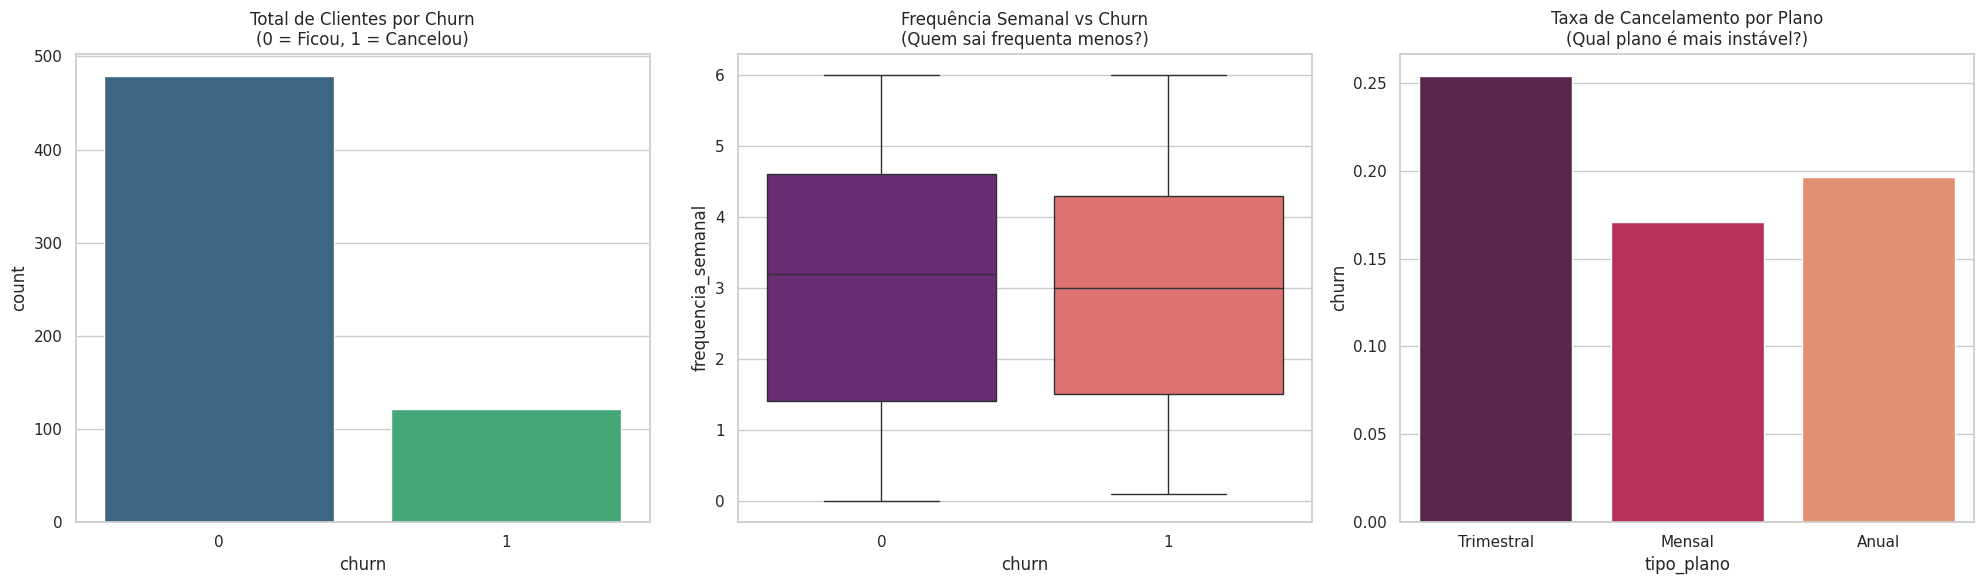

In [31]:
plt.figure(figsize=(20, 6))

#Distribuição de Churn (Quantas pessoas saíram vs ficaram)
plt.subplot(1, 3, 1)
sns.countplot(x='churn', data=df, hue='churn', palette='viridis', legend=False)
plt.title('Total de Clientes por Churn\n(0 = Ficou, 1 = Cancelou)')

#Frequência Semanal vs Churn
plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='frequencia_semanal', data=df, hue='churn', palette='magma', legend=False)
plt.title('Frequência Semanal vs Churn\n(Quem sai frequenta menos?)')

#Taxa de Churn por Tipo de Plano
plt.subplot(1, 3, 3)

sns.barplot(x='tipo_plano', y='churn', data=df, hue='tipo_plano', palette='rocket', ci=None, legend=False)
plt.title('Taxa de Cancelamento por Plano\n(Qual plano é mais instável?)')
df.groupby('tipo_plano')['churn'].mean() * 100

plt.tight_layout()
plt.show()

# SUSPEITA: Modelo do plano ou valor

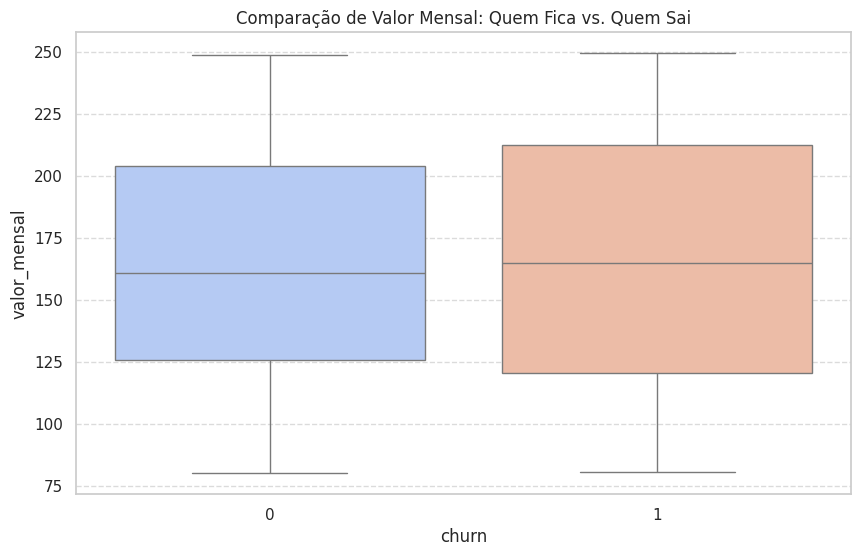

In [32]:
#validação da hipotese
plt.figure(figsize=(10, 6))

# Comparando o valor pago por quem ficou (0) e quem saiu (1)
sns.boxplot(x='churn', y='valor_mensal', data=df, hue='churn', palette='coolwarm', legend=False)

plt.title('Comparação de Valor Mensal: Quem Fica vs. Quem Sai')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
#tabela resumo
analise_preco = df.groupby(['tipo_plano', 'churn'])['valor_mensal'].mean().unstack()

print("Média de Valor Mensal pago:")
print(analise_preco)

print("\n--- Insight ---")
#diferença de preço no plano Mensal
diff = analise_preco.loc['Mensal', 1] - analise_preco.loc['Mensal', 0]
print(f"No plano Mensal, quem sai paga em média R${diff:.2f} a mais do que quem fica.")

Média de Valor Mensal pago:
churn                0           1
tipo_plano                        
Anual       163.858469  178.589167
Mensal      164.672263  165.303800
Trimestral  160.264203  161.109787

--- Insight ---
No plano Mensal, quem sai paga em média R$0.63 a mais do que quem fica.


Após análise do gráfico vs cálculo da média, notei que a diferença de valor média de quem fica para quem sai é muito baixa, apenas R$0.63

Nova hipótese: Junção de fatores (Reclamação, valor e frequencia)

/tmp/ipython-input-3438162702.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variavel', data=importancias, palette='mako')


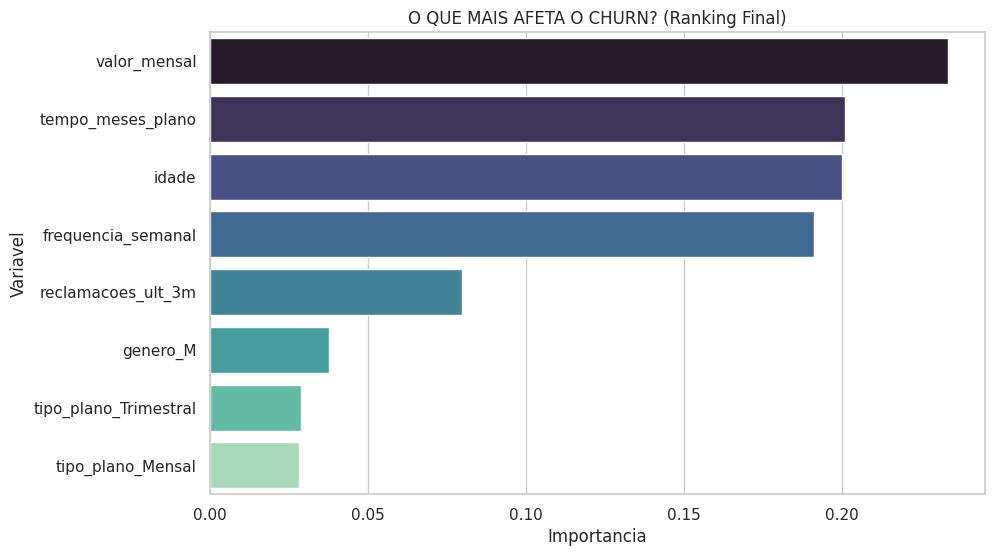


--- Top 3 Fatores Críticos ---
            Variavel  Importancia
3       valor_mensal     0.233615
1  tempo_meses_plano     0.200933
0              idade     0.199975


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

try:
    # 3. Separar X (preditores) e y (alvo)
    X = df_modelo.drop('churn', axis=1)
    y = df_modelo['churn']

    # 4. Treinar o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    # 5. Criar o Ranking de Importância
    importancias = pd.DataFrame({'Variavel': X.columns, 'Importancia': modelo.feature_importances_})
    importancias = importancias.sort_values(by='Importancia', ascending=False)

    # 6. Exibir o Gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importancia', y='Variavel', data=importancias, palette='mako')
    plt.title('O QUE MAIS AFETA O CHURN? (Ranking Final)')
    plt.show()

    print("\n--- Top 3 Fatores Críticos ---")
    print(importancias.head(3))

except FileNotFoundError:
    print("Erro: O arquivo 'varejo_churn_academia.csv' não foi encontrado. Por favor, faça o upload dele novamente no painel lateral.")


/tmp/ipython-input-4234776480.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tipo_plano', y='churn', data=taxa_plano, palette='Reds_r')


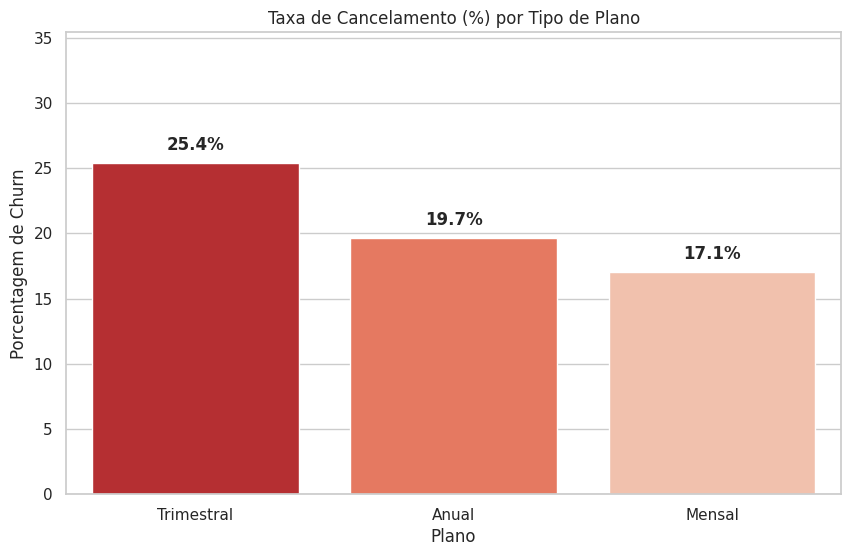

Valores exatos:
   tipo_plano      churn
2  Trimestral  25.405405
0       Anual  19.672131
1      Mensal  17.064846


In [35]:
# 1. Calculando a taxa de cancelamento (média do churn) por plano
taxa_plano = df.groupby('tipo_plano')['churn'].mean() * 100

# 2. Transformando em um DataFrame para facilitar a visualização
taxa_plano = taxa_plano.reset_index().sort_values(by='churn', ascending=False)

# 3. Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='tipo_plano', y='churn', data=taxa_plano, palette='Reds_r')

# Adicionando os valores em cima das barras
for i, valor in enumerate(taxa_plano['churn']):
    plt.text(i, valor + 1, f'{valor:.1f}%', ha='center', fontweight='bold')

plt.title('Taxa de Cancelamento (%) por Tipo de Plano')
plt.ylabel('Porcentagem de Churn')
plt.xlabel('Plano')
plt.ylim(0, max(taxa_plano['churn']) + 10)
plt.show()

print("Valores exatos:")
print(taxa_plano)

In [36]:
# Criando a tabela de resumo de faturamento e volume
resumo_financeiro = df.groupby('tipo_plano').agg(
    qtd_clientes=('tipo_plano', 'count'),
    valor_medio_plano=('valor_mensal', 'mean'),
    faturamento_total=('valor_mensal', 'sum')
).reset_index()

# Formatando os valores para ficar mais fácil de ler
resumo_financeiro['valor_medio_plano'] = resumo_financeiro['valor_medio_plano'].map('R$ {:,.2f}'.format)
resumo_financeiro['faturamento_total'] = resumo_financeiro['faturamento_total'].map('R$ {:,.2f}'.format)

print("--- ANÁLISE DE VOLUME E VALOR POR PLANO ---")
print(resumo_financeiro.to_string(index=False))

--- ANÁLISE DE VOLUME E VALOR POR PLANO ---
tipo_plano  qtd_clientes valor_medio_plano faturamento_total
     Anual           122         R$ 166.76      R$ 20,344.27
    Mensal           293         R$ 164.78      R$ 48,280.55
Trimestral           185         R$ 160.48      R$ 29,688.62


/tmp/ipython-input-3097848704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tipo_plano', y='reclamacoes_ult_3m', data=reclamacoes_plano, palette='Oranges_r')


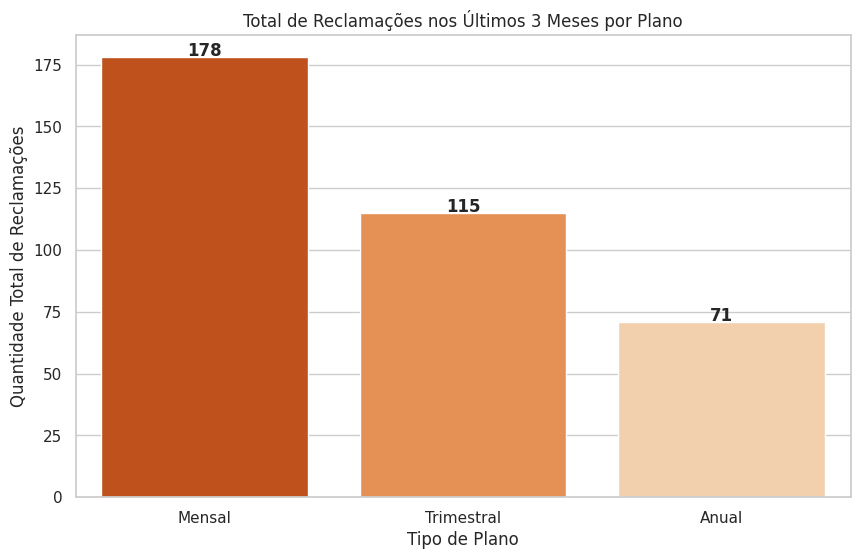


Média de reclamações por cliente:
tipo_plano
Anual         0.581967
Mensal        0.607509
Trimestral    0.621622
Name: reclamacoes_ult_3m, dtype: float64


In [37]:
# 1. Somando o total de reclamações por plano
reclamacoes_plano = df.groupby('tipo_plano')['reclamacoes_ult_3m'].sum().reset_index()

# 2. Ordenando para o gráfico ficar mais claro
reclamacoes_plano = reclamacoes_plano.sort_values(by='reclamacoes_ult_3m', ascending=False)

# 3. Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='tipo_plano', y='reclamacoes_ult_3m', data=reclamacoes_plano, palette='Oranges_r')

# Adicionando os números exatos em cima das barras
for i, v in enumerate(reclamacoes_plano['reclamacoes_ult_3m']):
    plt.text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')

plt.title('Total de Reclamações nos Últimos 3 Meses por Plano')
plt.ylabel('Quantidade Total de Reclamações')
plt.xlabel('Tipo de Plano')
plt.show()

# 4. Calculando a MÉDIA de reclamações por pessoa em cada plano
print("\nMédia de reclamações por cliente:")
print(df.groupby('tipo_plano')['reclamacoes_ult_3m'].mean())

# Validação de frequencia x plano

/tmp/ipython-input-12310025.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='tipo_plano', y='frequencia_semanal', data=df, palette='GnBu_r', ci=None)
/tmp/ipython-input-12310025.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tipo_plano', y='frequencia_semanal', data=df, palette='GnBu_r', ci=None)


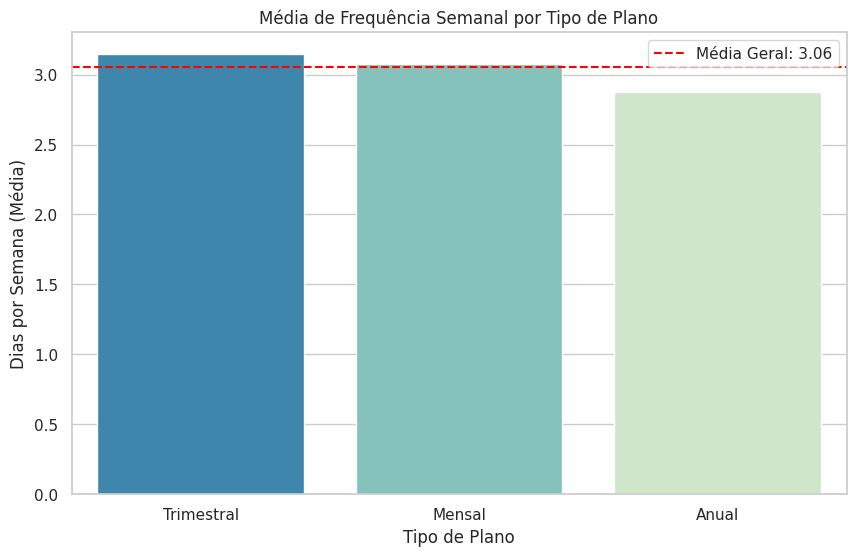

/tmp/ipython-input-12310025.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tipo_plano', y='frequencia_semanal', data=df, palette='GnBu_r')


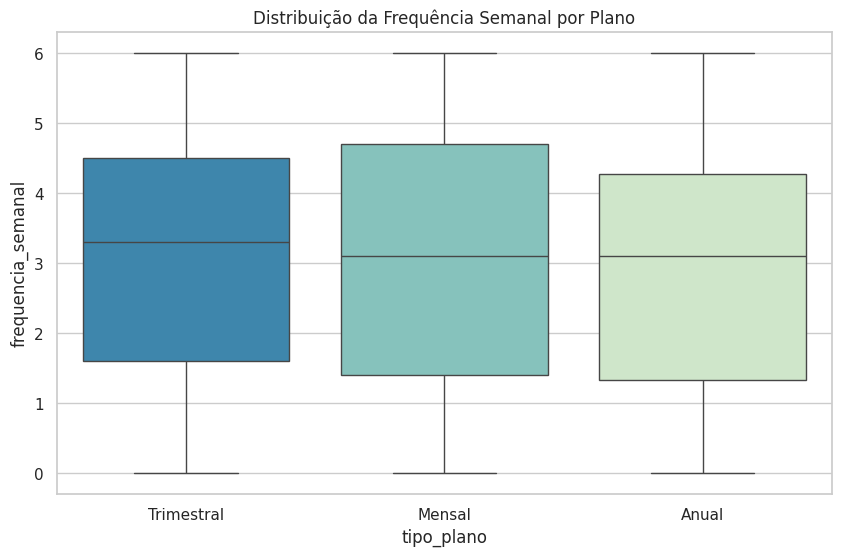

In [38]:
# 1. Calculando a média de frequência semanal por plano
freq_plano = df.groupby('tipo_plano')['frequencia_semanal'].mean().reset_index()

# 2. Criando o gráfico para comparar as médias
plt.figure(figsize=(10, 6))
sns.barplot(x='tipo_plano', y='frequencia_semanal', data=df, palette='GnBu_r', ci=None)

# Adicionando a linha da média geral da academia para comparação
media_geral = df['frequencia_semanal'].mean()
plt.axhline(media_geral, color='red', linestyle='--', label=f'Média Geral: {media_geral:.2f}')

plt.title('Média de Frequência Semanal por Tipo de Plano')
plt.ylabel('Dias por Semana (Média)')
plt.xlabel('Tipo de Plano')
plt.legend()
plt.show()

# 3. Visão detalhada com Boxplot (para ver a consistência)
plt.figure(figsize=(10, 6))
sns.boxplot(x='tipo_plano', y='frequencia_semanal', data=df, palette='GnBu_r')
plt.title('Distribuição da Frequência Semanal por Plano')
plt.show()

In [39]:
# Filtrando clientes do plano Trimestral, com alta frequência e que já reclamaram
clientes_risco_critico = df[
    (df['tipo_plano'] == 'Trimestral') &
    (df['frequencia_semanal'] > 3) &
    (df['reclamacoes_ult_3m'] > 0) &
    (df['churn'] == 0) # Apenas quem ainda não saiu
]

print(f"Encontramos {len(clientes_risco_critico)} clientes em risco crítico no plano Trimestral.")
clientes_risco_critico[['cliente_id', 'idade', 'frequencia_semanal', 'reclamacoes_ult_3m']].head()

Encontramos 36 clientes em risco crítico no plano Trimestral.


,cliente_id,idade,frequencia_semanal,reclamacoes_ult_3m
11,12,41,5.2,1
12,13,53,5.9,1
42,43,35,3.9,2
54,55,25,5.6,1
59,60,53,4.2,1


# ANALISE DE IDADE VS CHURN

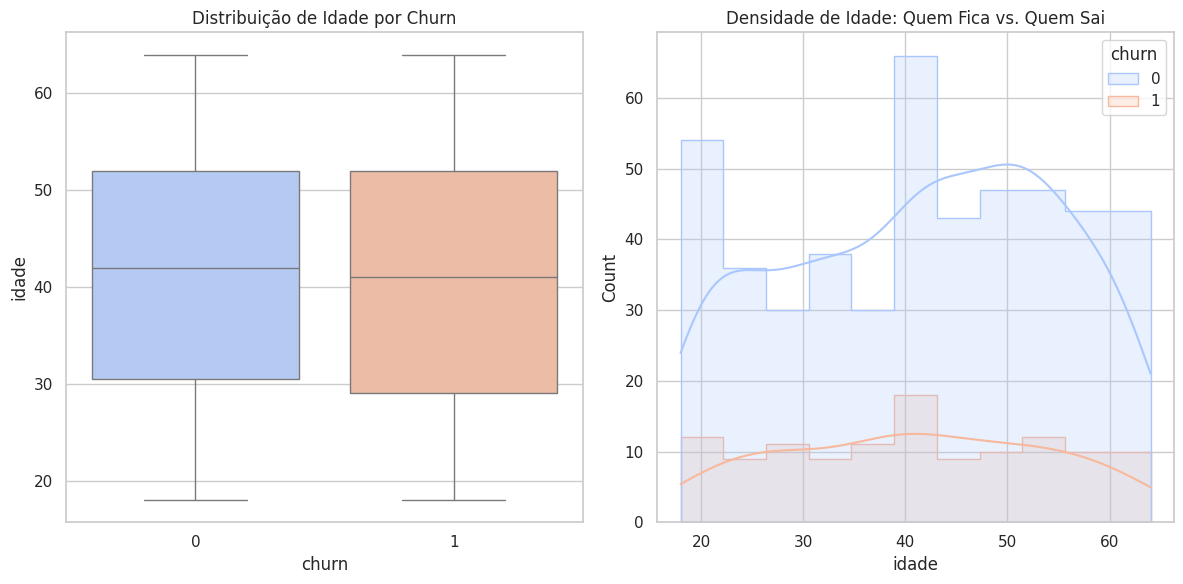

Média de idade por grupo:
churn
0    41.544885
1    40.851240
Name: idade, dtype: float64


In [40]:
plt.figure(figsize=(12, 6))

# 1. Boxplot para ver a distribuição de idade por Churn
plt.subplot(1, 2, 1)
sns.boxplot(x='churn', y='idade', data=df, hue='churn', palette='coolwarm', legend=False)
plt.title('Distribuição de Idade por Churn')

# 2. Histograma para ver em quais idades o cancelamento se concentra
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='idade', hue='churn', kde=True, element='step', palette='coolwarm')
plt.title('Densidade de Idade: Quem Fica vs. Quem Sai')

plt.tight_layout()
plt.show()

# Média de idade por grupo
print("Média de idade por grupo:")
print(df.groupby('churn')['idade'].mean())

/tmp/ipython-input-3678393405.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_genero.index, y=churn_genero.values, palette='magma')


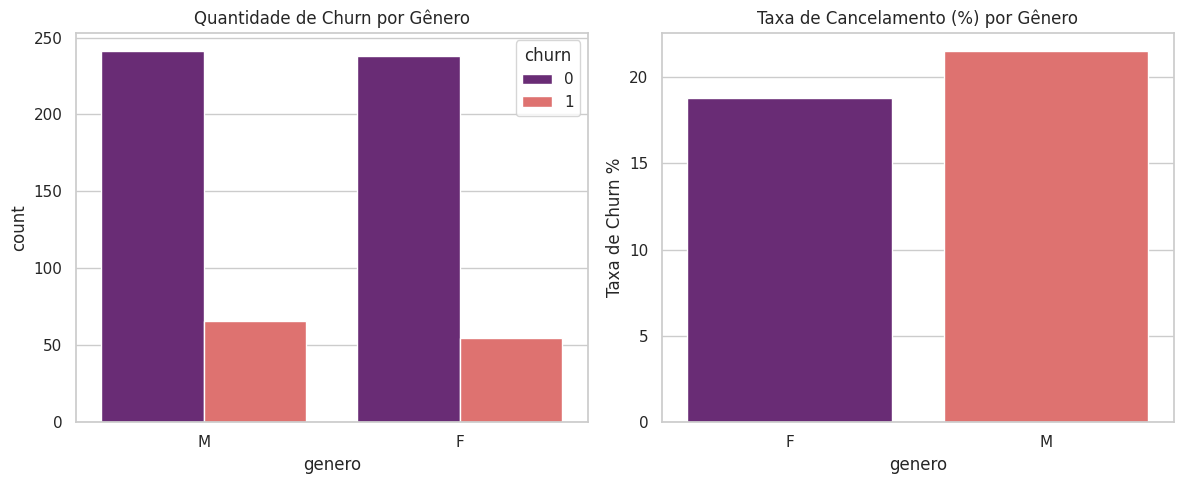

Taxa exata de cancelamento por gênero:
genero
F    18.771331
M    21.498371
Name: churn, dtype: float64


In [41]:
plt.figure(figsize=(12, 5))

# 1. Quantidade de homens e mulheres por Churn
plt.subplot(1, 2, 1)
sns.countplot(x='genero', hue='churn', data=df, palette='magma')
plt.title('Quantidade de Churn por Gênero')

# 2. Porcentagem de cancelamento por gênero
plt.subplot(1, 2, 2)
churn_genero = df.groupby('genero')['churn'].mean() * 100
sns.barplot(x=churn_genero.index, y=churn_genero.values, palette='magma')
plt.title('Taxa de Cancelamento (%) por Gênero')
plt.ylabel('Taxa de Churn %')

plt.tight_layout()
plt.show()

print("Taxa exata de cancelamento por gênero:")
print(churn_genero)

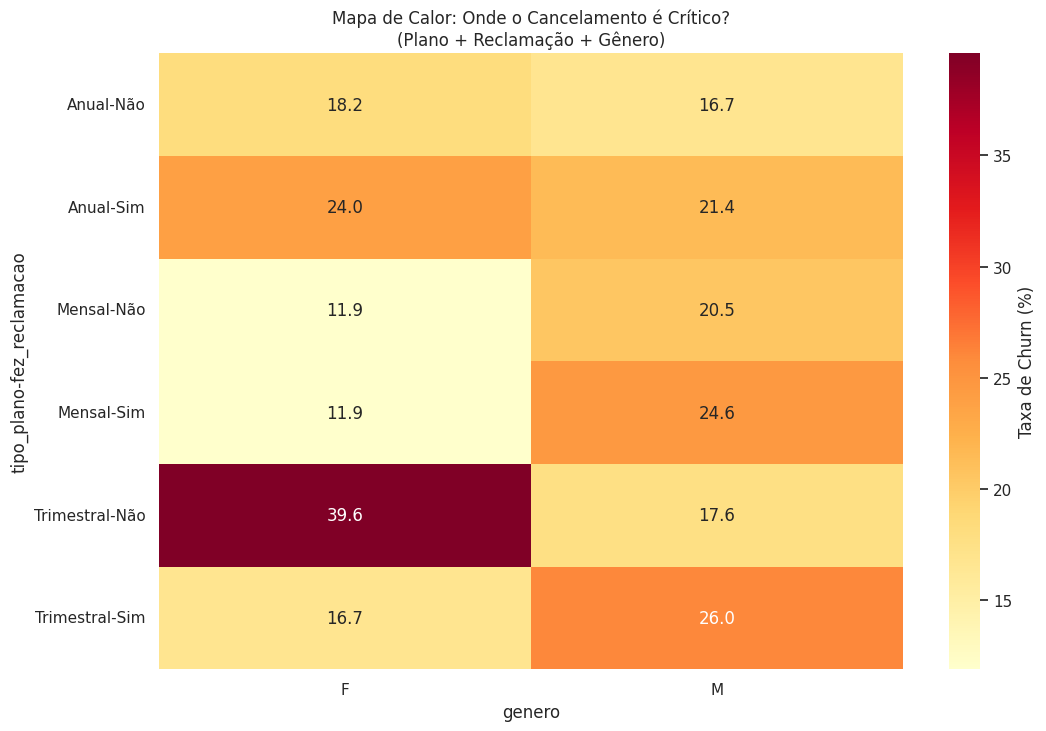

In [42]:
# 1. Criando uma coluna binária para simplificar: "Reclamou" ou "Não Reclamou"
df['fez_reclamacao'] = df['reclamacoes_ult_3m'].apply(lambda x: 'Sim' if x > 0 else 'Não')

# 2. Criando uma tabela dinâmica para cruzar os dados
pivot_churn = df.pivot_table(
    index=['tipo_plano', 'fez_reclamacao'],
    columns='genero',
    values='churn',
    aggfunc='mean'
) * 100

# 3. Gerando o Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_churn, annot=True, fmt=".1f", cmap='YlOrRd', cbar_kws={'label': 'Taxa de Churn (%)'})
plt.title('Mapa de Calor: Onde o Cancelamento é Crítico?\n(Plano + Reclamação + Gênero)')
plt.show()

/tmp/ipython-input-4012550940.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_idade = df_mulheres.pivot_table(


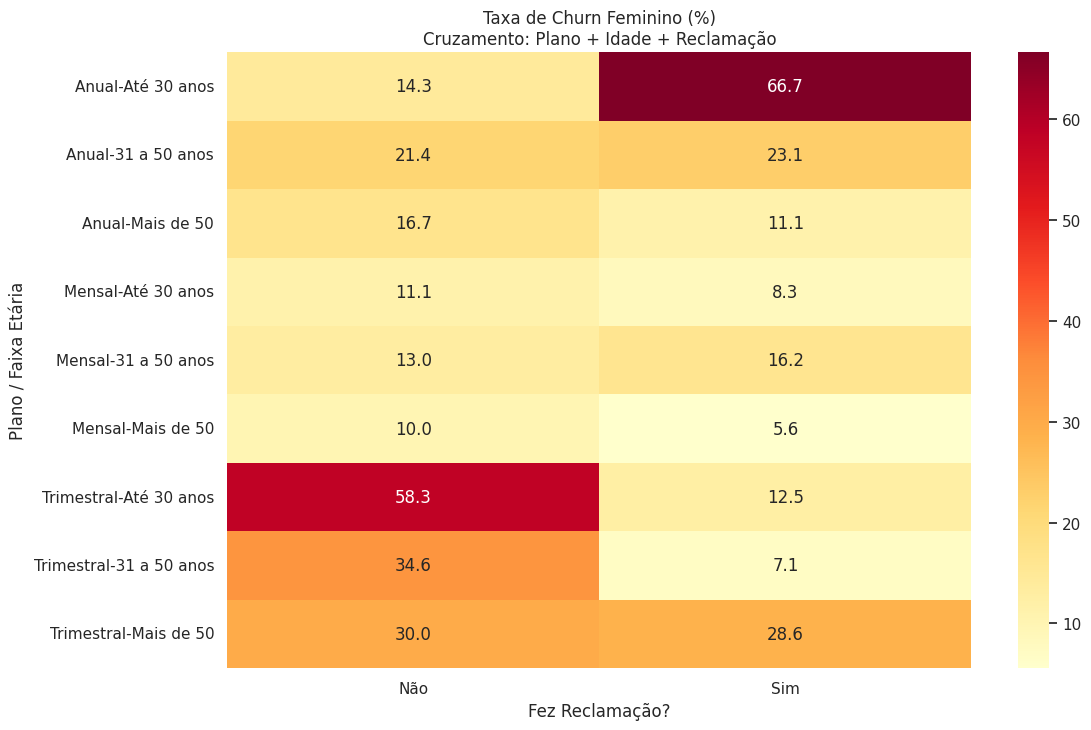

In [43]:
# 1. Criando Faixas Etárias para o gráfico não ficar gigante
# dividir em Jovens (até 30), Adultos (31-50) e Sênior (50+)
df['faixa_etaria'] = pd.cut(df['idade'], bins=[0, 30, 50, 100], labels=['Até 30 anos', '31 a 50 anos', 'Mais de 50'])

# 2. Criando a tabela dinâmica cruzando Gênero, Plano e agora a FAIXA ETÁRIA
# Filtramos apenas para as mulheres (F), já que o risco está nelas
df_mulheres = df[df['genero'] == 'F']

pivot_idade = df_mulheres.pivot_table(
    index=['tipo_plano', 'faixa_etaria'],
    columns='fez_reclamacao',
    values='churn',
    aggfunc='mean'
) * 100

# 3. Gerando o Heatmap focado no perfil feminino
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_idade, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Taxa de Churn Feminino (%)\nCruzamento: Plano + Idade + Reclamação')
plt.xlabel('Fez Reclamação?')
plt.ylabel('Plano / Faixa Etária')
plt.show()

In [44]:
# 1. Criando as classificações que descobrimos
def classificar_risco(linha):
    # O padrão que você descobriu: Mulher, Jovem, Plano Trimestral
    if linha['genero'] == 'F' and linha['idade'] <= 30 and linha['tipo_plano'] == 'Trimestral':
        return 'Alvo Prioritário (Risco Silencioso)'
    # Outro padrão: Reclamações no Plano Mensal
    elif linha['reclamacoes_ult_3m'] > 0 and linha['tipo_plano'] == 'Mensal':
        return 'Risco por Insatisfação'
    # Caso contrário, é um cliente padrão
    else:
        return 'Perfil Estável'

# 2. Aplicando a lógica ao nosso banco de dados
df['segmento_analise'] = df.apply(classificar_risco, axis=1)

# 3. Exportando o arquivo que você vai abrir no Power BI
df.to_csv('projeto_churn_final.csv', index=False)

print("Arquivo 'projeto_churn_final.csv' gerado com sucesso!")

Arquivo 'projeto_churn_final.csv' gerado com sucesso!


/tmp/ipython-input-1242675837.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=taxas, y=segmentos, ax=axes[0, 0], palette='Reds_r')


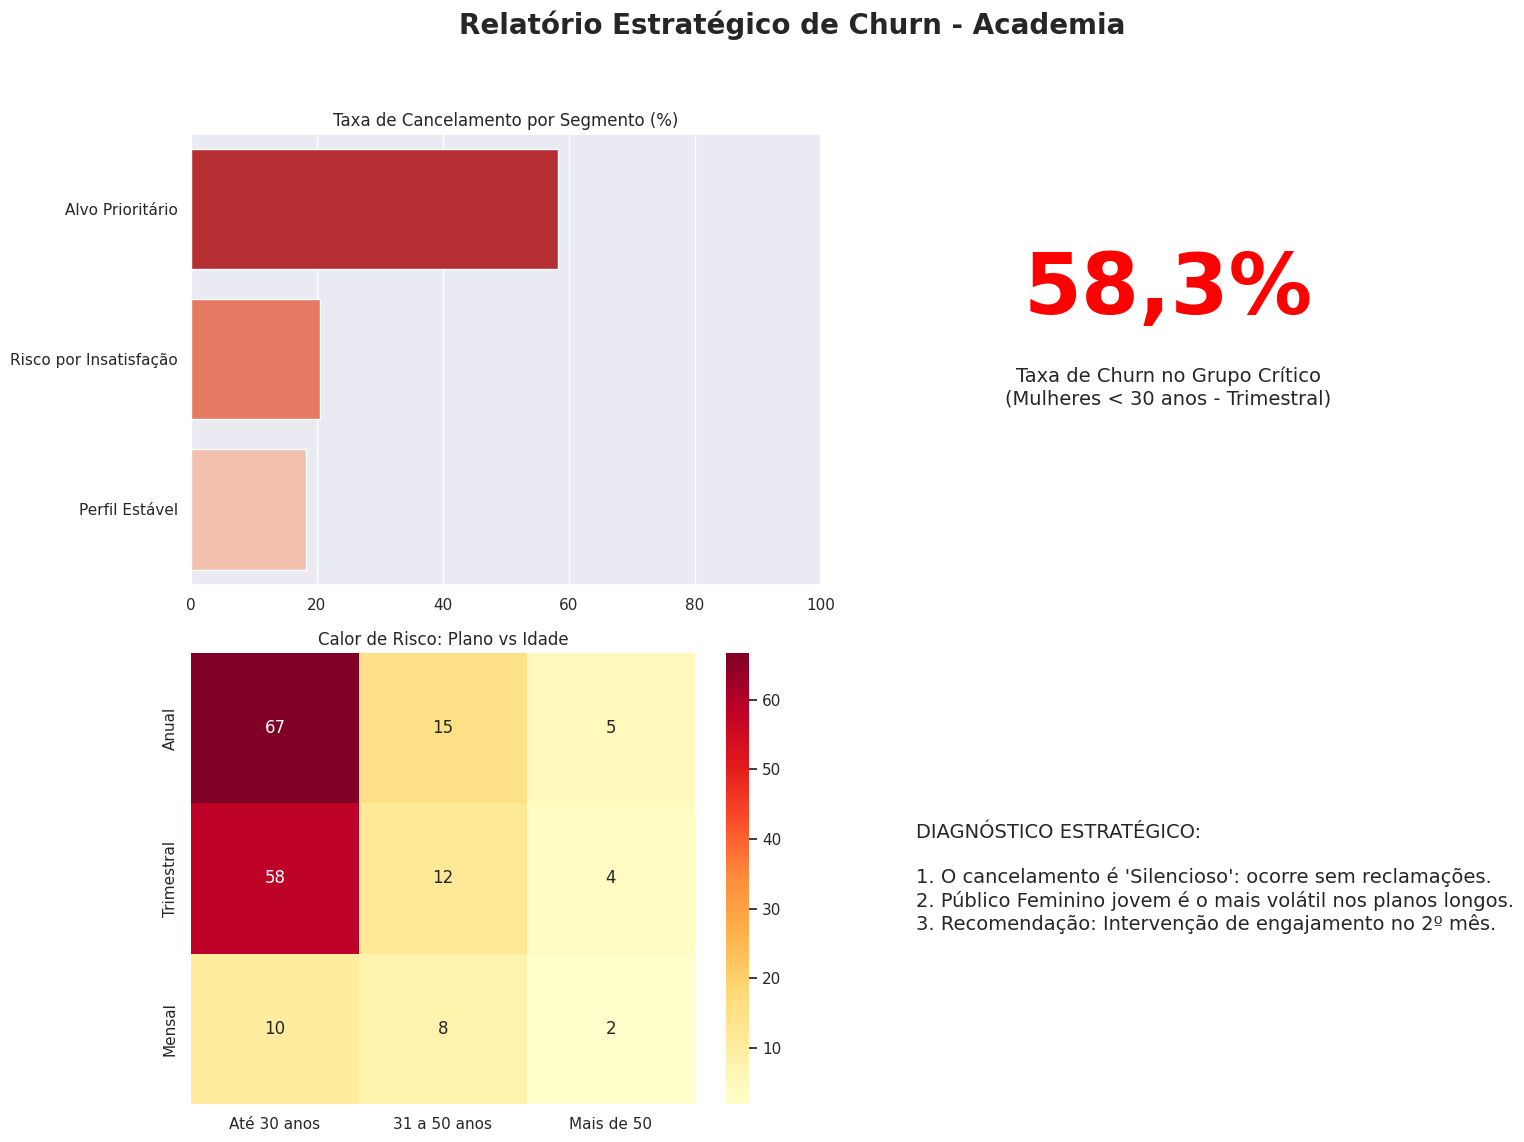

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Relatório Estratégico de Churn - Academia', fontsize=20, fontweight='bold')

# 1. Gráfico de Barras: Taxa de Churn por Segmento
# Dados baseados na sua análise anterior
segmentos = ['Alvo Prioritário', 'Risco por Insatisfação', 'Perfil Estável']
taxas = [58.3, 20.5, 18.2] #
sns.barplot(x=taxas, y=segmentos, ax=axes[0, 0], palette='Reds_r')
axes[0, 0].set_title('Taxa de Cancelamento por Segmento (%)')
axes[0, 0].set_xlim(0, 100)

# 2. KPI: O grande Insight
axes[0, 1].text(0.5, 0.6, '58,3%', fontsize=60, ha='center', color='red', fontweight='bold')
axes[0, 1].text(0.5, 0.4, 'Taxa de Churn no Grupo Crítico\n(Mulheres < 30 anos - Trimestral)', fontsize=14, ha='center')
axes[0, 1].axis('off')

# 3. Mapa de Calor (Simulando a Matriz de Risco)
# Focando nos planos e faixas etárias críticos
import pandas as pd
dados_calor = pd.DataFrame({
    'Até 30 anos': [66.7, 58.3, 10.5], #
    '31 a 50 anos': [15.0, 12.0, 8.0],
    'Mais de 50': [5.0, 4.0, 2.0]
}, index=['Anual', 'Trimestral', 'Mensal'])
sns.heatmap(dados_calor, annot=True, cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Calor de Risco: Plano vs Idade')

# 4. Texto de Conclusão (Insight de Negócio)
texto_insight = (
    "DIAGNÓSTICO ESTRATÉGICO:\n\n"
    "1. O cancelamento é 'Silencioso': ocorre sem reclamações.\n"
    "2. Público Feminino jovem é o mais volátil nos planos longos.\n"
    "3. Recomendação: Intervenção de engajamento no 2º mês."
)
axes[1, 1].text(0.1, 0.5, texto_insight, fontsize=14, va='center', ha='left', wrap=True)
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()